In [297]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import glob
import pandas as pd
import os
import matplotlib as mpl
from numpy import concatenate as cat
from collections import defaultdict
from sklearn import metrics
mpl.rcParams['figure.dpi'] = 250
pd.set_option('precision', 3)
DATASET = 'tbi/log'

if 'tbi' in DATASET or 'csi' in DATASET:
    seeds = range(10)

if DATASET == 'sim':
    seeds = range(10)
    sens_levels = []
    metrics_ = ['auc', 'aps', 'acc', 'f1']
else:
    sens_levels = [0.92, 0.94, 0.96, 0.98]
    metrics_ = ['high_spec_avg', 'spec_0.92', 'spec_0.94', 'spec_0.96', 'spec_0.98', 'auc', 'aps', 'acc']

In [298]:
def plott(model_name, sens, spec, ppv, ax):
    if 'pecarn' in model_name.lower():
        ax.plot(sens[0], spec[0], '.-', label=model_name)
    else:
        ax.plot(sens, spec, '.-', label=model_name)

In [299]:
def multiplot(paths, ax, suffix=""):
    for model_file in paths:
        basename = os.path.basename(model_file).split('.')[0]
        dct = pkl.load(open(model_file, 'rb'))
        plott(basename, dct['sens_tune'], dct['spec_tune'], dct['ppv_tune'], ax)
    ax.legend(frameon=False, loc='best')
    ax.set_xlim(0.5, 1.05)
    # ax.set_ylim(0, 0.2)

In [300]:
def multiseedplot(group='all'):
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    for k, i in enumerate(seeds[:6]):
        paths = sorted(glob.glob(f'results/{DATASET}/seed_{i}/{group}/*.pkl'))
        multiplot(paths, axes[k // 3, k % 3], group)
    plt.xlabel('sens')
    plt.ylabel('spec')
    plt.tight_layout()

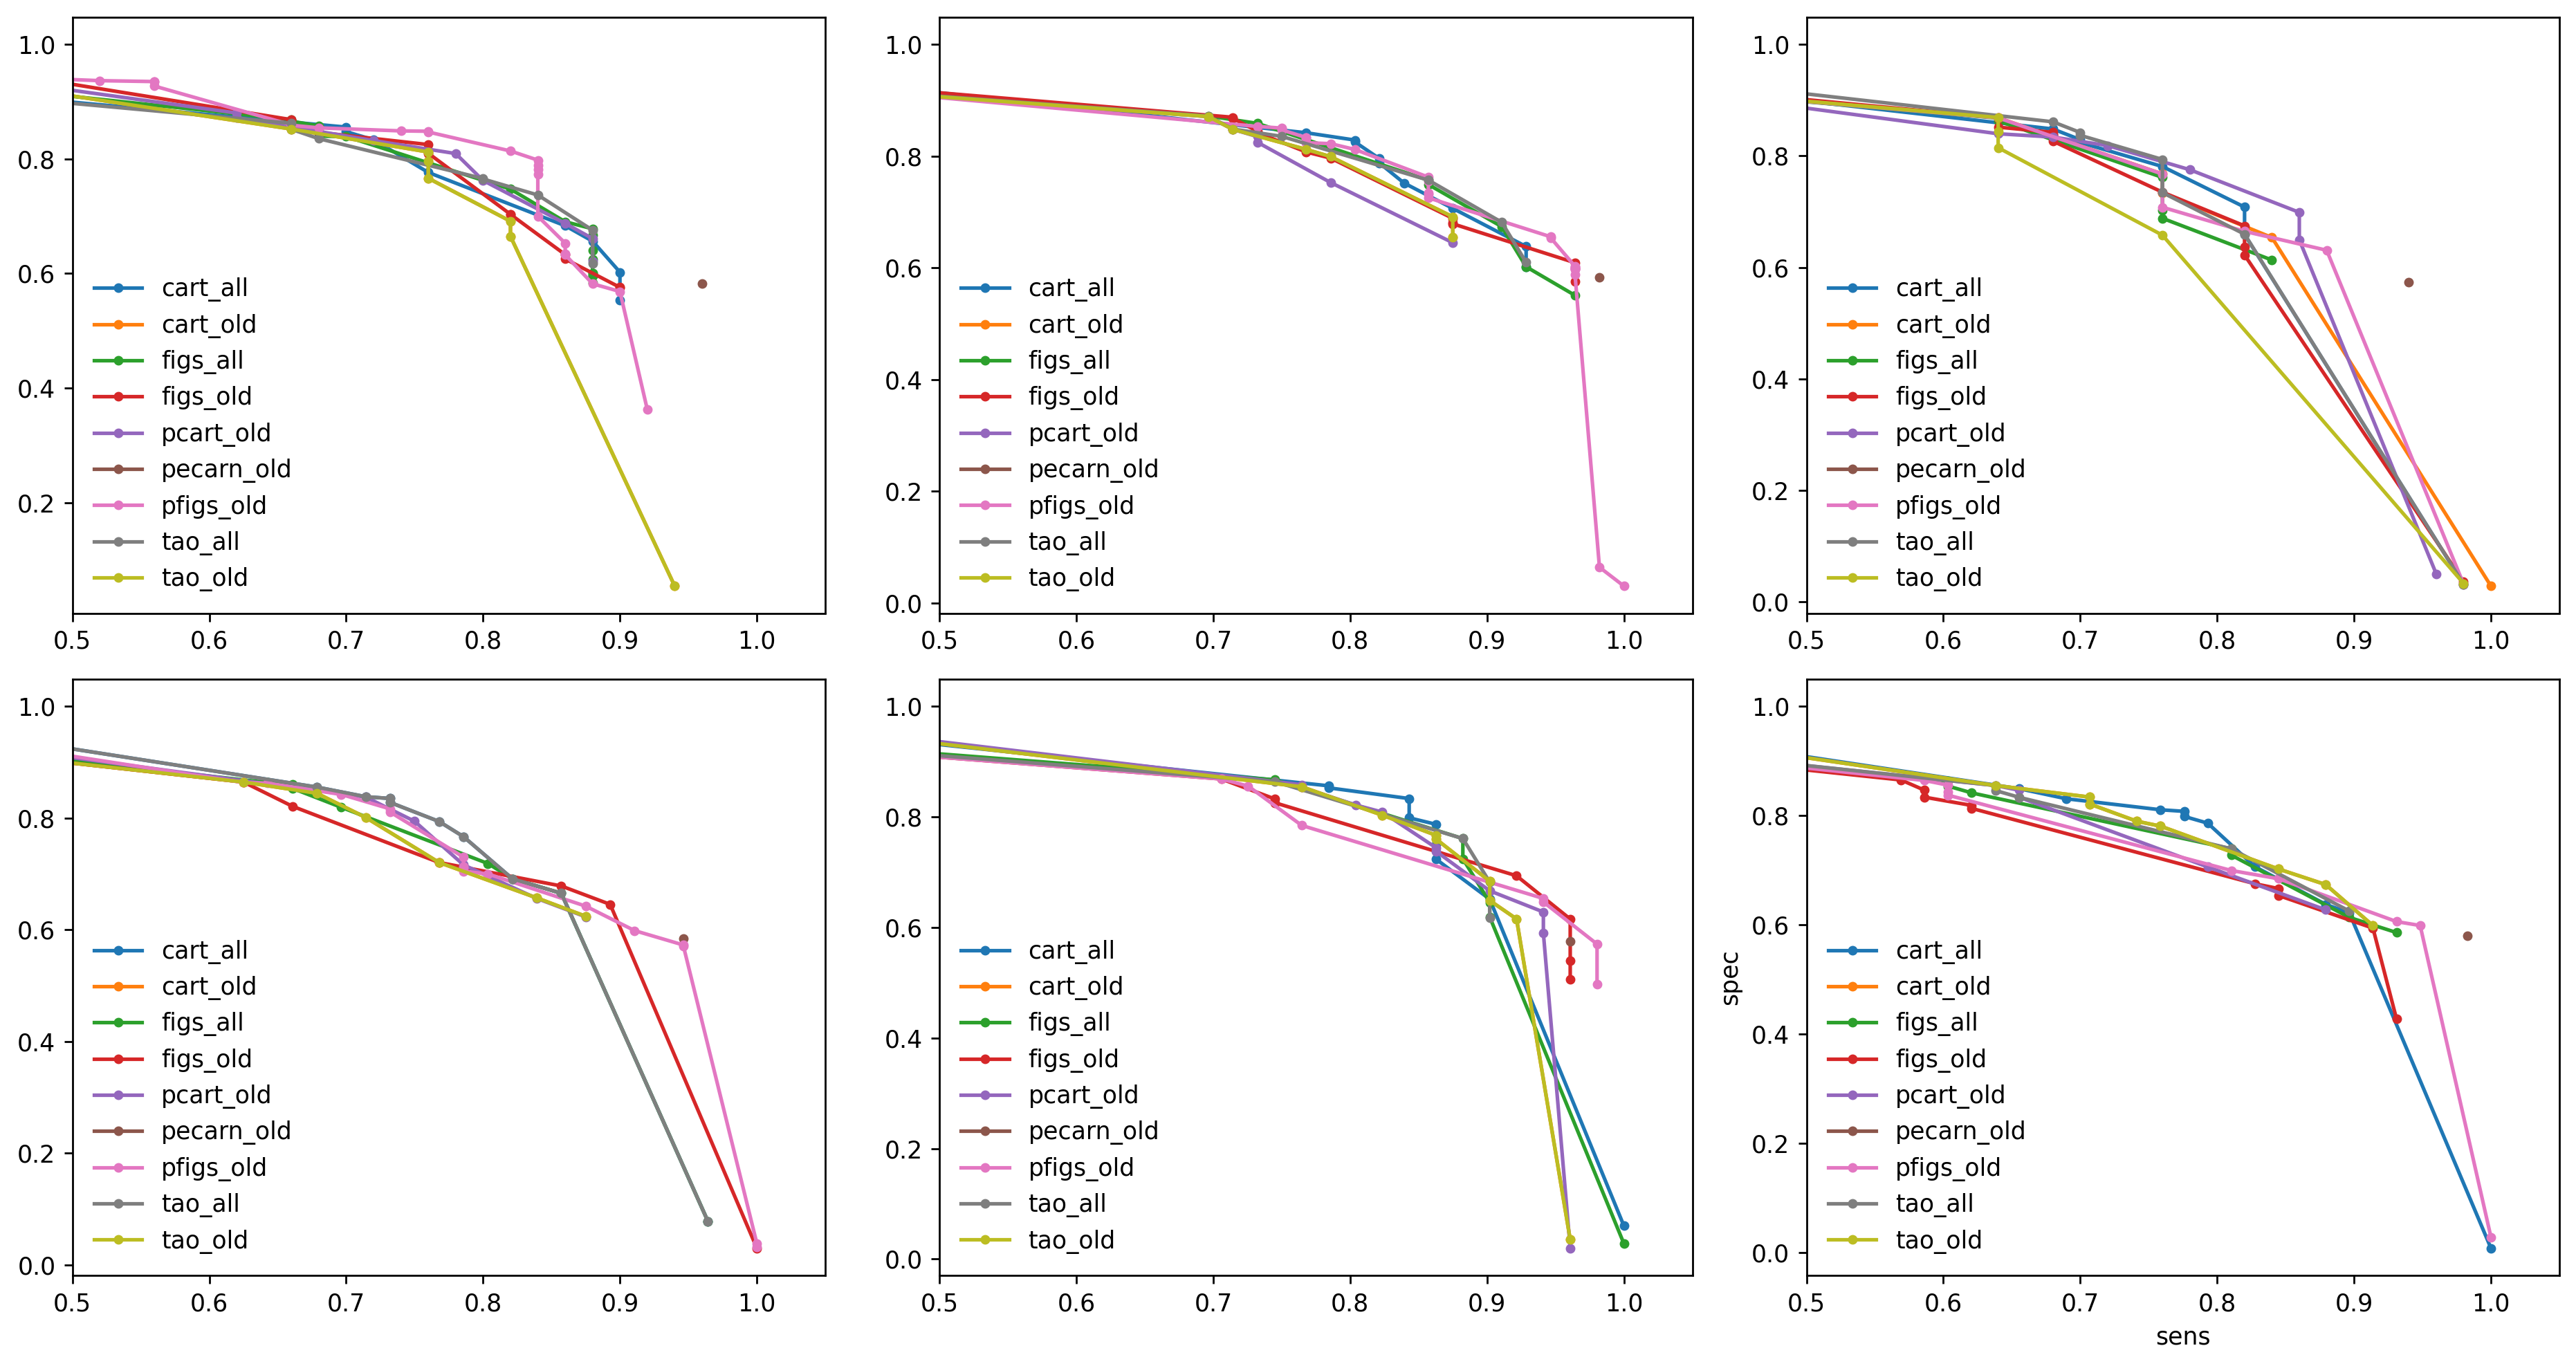

In [301]:
multiseedplot(group='old')

In [252]:
# multiseedplot(group='young')

In [253]:
# multiseedplot(group='old')

In [302]:
def pkl_to_table(group):
    table = defaultdict(lambda:[])
    for i in seeds:
        seed_paths = sorted(glob.glob(f'results/{DATASET}/seed_{i}/{group}/*.pkl'))
        table_index = [os.path.basename(f).split('.')[0] for f in seed_paths]
        for model_file in seed_paths:
            dct = pkl.load(open(model_file, 'rb'))
            specs = np.array(dct['spec_tune'])
            senses = np.array(dct['sens_tune'])
            precisions = np.array(dct['ppv_tune'])
            for sens in sens_levels:
                table[f'spec_{sens}_seed_{i}'].append(
                    np.max(specs[senses > sens]) if specs[senses > sens].shape[0] > 0 else 0.0)
            table[f'auc_seed_{i}'].append(metrics.auc(1 - specs, senses))
            # table[f'auprc_seed_{i}'].append(metrics.auc(senses, np.nan_to_num(precisions, nan=1)))
            table[f'aps_seed_{i}'].append(-np.sum(np.diff(senses) * np.array(precisions)[:-1]))
            table[f'acc_seed_{i}'].append(dct['acc'])
            # table[f'f1_seed_{i}'].append(np.max((2 * np.array(senses)[:-1] * np.array(precisions)[:-1]) / (np.array(senses)[:-1] + np.array(precisions)[:-1])))
        
    res_table = pd.DataFrame(table, index=table_index)
    if sens_levels:
        for i in seeds:
            res_table[f'high_spec_avg_seed_{i}'] = res_table.loc[
                :, [f'spec_0.92_seed_{i}', f'spec_0.94_seed_{i}', f'spec_0.96_seed_{i}', f'spec_0.98_seed_{i}']].mean(axis=1)

    for metric in metrics_:
        res_table_metric = res_table.loc[:, res_table.columns.str.contains(metric)]
        res_table[metric] = res_table_metric.mean(axis=1)

    # res_table['high_spec_avg'] = res_table[
    #     [f'spec_0.94', f'spec_0.96', f'spec_0.98']].mean(axis=1)

    for metric in metrics_:
        res_table_metric = res_table.loc[:, res_table.columns.str.contains(metric)]
        res_table[f'{metric}_std_err'] = res_table_metric.std(axis=1) / np.sqrt(10)
        # res_table[f'{metric}_std'] = res_table_metric.std(axis=1)
        
    return res_table

In [307]:
pkl_to_table('all').to_csv(f'results/{DATASET}/all_average.csv')
pkl_to_table('young').to_csv(f'results/{DATASET}/young_average.csv')
pkl_to_table('old').to_csv(f'results/{DATASET}/old_average.csv')

In [308]:
pkl_to_table('all').iloc[:, -16:].style.highlight_max(color='blue')

,high_spec_avg,spec_0.92,spec_0.94,spec_0.96,spec_0.98,auc,aps,acc,high_spec_avg_std_err,spec_0.92_std_err,spec_0.94_std_err,spec_0.96_std_err,spec_0.98_std_err,auc_std_err,aps_std_err,acc_std_err
cart_all,0.109,0.206,0.142,0.072,0.015,0.591,0.054,0.770,0.050,0.089,0.077,0.058,0.006,0.082,0.003,0.011
cart_combine,0.111,0.171,0.138,0.114,0.022,0.732,0.050,0.778,0.044,0.051,0.056,0.058,0.017,0.020,0.003,0.008
figmix_old,0.167,0.372,0.175,0.107,0.013,0.634,0.047,0.701,0.042,0.075,0.062,0.064,0.007,0.053,0.004,0.007
figmix_young,0.204,0.369,0.280,0.136,0.032,0.682,0.040,0.728,0.052,0.083,0.077,0.058,0.014,0.057,0.003,0.010
figs_all,0.160,0.253,0.193,0.181,0.013,0.535,0.042,0.695,0.061,0.091,0.083,0.081,0.005,0.083,0.003,0.007
figs_combine,0.153,0.256,0.179,0.159,0.018,0.608,0.045,0.707,0.056,0.084,0.071,0.073,0.009,0.069,0.003,0.005
pcart_combine,0.183,0.301,0.224,0.156,0.050,0.755,0.043,0.784,0.050,0.071,0.072,0.059,0.024,0.022,0.003,0.012
pecarn_combine,0.411,0.567,0.567,0.454,0.057,0.209,0.019,0.571,0.024,0.001,0.001,0.072,0.054,0.001,0.001,0.001
pfigs_combine,0.184,0.411,0.180,0.111,0.036,0.713,0.042,0.722,0.044,0.071,0.067,0.049,0.018,0.044,0.004,0.009
tao_all,0.088,0.138,0.138,0.067,0.010,0.405,0.045,0.768,0.053,0.080,0.080,0.061,0.007,0.079,0.003,0.013


In [309]:
pkl_to_table('young').iloc[:, -16:].style.highlight_max(color='blue')

,high_spec_avg,spec_0.92,spec_0.94,spec_0.96,spec_0.98,auc,aps,acc,high_spec_avg_std_err,spec_0.92_std_err,spec_0.94_std_err,spec_0.96_std_err,spec_0.98_std_err,auc_std_err,aps_std_err,acc_std_err
cart_all,0.110,0.184,0.184,0.065,0.006,0.526,0.069,0.796,0.053,0.088,0.088,0.055,0.004,0.087,0.007,0.016
cart_young,0.046,0.088,0.082,0.006,0.006,0.519,0.052,0.807,0.035,0.070,0.071,0.004,0.004,0.091,0.009,0.014
figs_all,0.189,0.315,0.254,0.122,0.063,0.506,0.045,0.675,0.064,0.097,0.093,0.070,0.049,0.081,0.006,0.007
figs_young,0.138,0.238,0.178,0.067,0.067,0.412,0.051,0.776,0.059,0.085,0.078,0.058,0.058,0.085,0.011,0.011
pcart_young,0.165,0.219,0.216,0.144,0.081,0.538,0.041,0.802,0.079,0.094,0.094,0.087,0.071,0.084,0.004,0.012
pecarn_young,0.495,0.535,0.535,0.482,0.428,0.231,0.020,0.539,0.028,0.004,0.004,0.051,0.068,0.002,0.001,0.004
pfigs_young,0.224,0.310,0.309,0.174,0.102,0.638,0.045,0.751,0.080,0.102,0.102,0.090,0.069,0.066,0.010,0.015
tao_all,0.064,0.124,0.124,0.004,0.004,0.328,0.052,0.786,0.041,0.079,0.079,0.004,0.004,0.077,0.006,0.020
tao_young,0.082,0.086,0.080,0.080,0.080,0.526,0.052,0.811,0.069,0.069,0.069,0.069,0.069,0.089,0.009,0.013


In [310]:
pkl_to_table('old').iloc[:, -16:].style.highlight_max(color='blue')

,high_spec_avg,spec_0.92,spec_0.94,spec_0.96,spec_0.98,auc,aps,acc,high_spec_avg_std_err,spec_0.92_std_err,spec_0.94_std_err,spec_0.96_std_err,spec_0.98_std_err,auc_std_err,aps_std_err,acc_std_err
cart_all,0.130,0.214,0.148,0.142,0.015,0.591,0.052,0.761,0.057,0.090,0.078,0.074,0.007,0.082,0.003,0.010
cart_old,0.114,0.253,0.128,0.068,0.006,0.520,0.048,0.768,0.048,0.093,0.076,0.055,0.004,0.084,0.003,0.009
figs_all,0.179,0.318,0.193,0.193,0.013,0.543,0.043,0.701,0.059,0.093,0.083,0.083,0.006,0.083,0.003,0.009
figs_old,0.161,0.255,0.200,0.187,0.003,0.528,0.047,0.684,0.064,0.090,0.088,0.086,0.003,0.065,0.003,0.006
pcart_old,0.145,0.260,0.194,0.128,0.000,0.368,0.044,0.778,0.061,0.098,0.090,0.079,0.000,0.069,0.003,0.013
pecarn_old,0.362,0.578,0.463,0.289,0.116,0.202,0.018,0.581,0.047,0.001,0.073,0.091,0.074,0.001,0.001,0.001
pfigs_old,0.237,0.379,0.310,0.186,0.073,0.631,0.042,0.712,0.070,0.096,0.096,0.083,0.053,0.068,0.002,0.012
tao_all,0.120,0.199,0.136,0.136,0.009,0.410,0.046,0.762,0.059,0.089,0.078,0.078,0.008,0.076,0.003,0.012
tao_old,0.113,0.253,0.129,0.068,0.003,0.515,0.048,0.775,0.048,0.093,0.076,0.055,0.003,0.082,0.003,0.009
